<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

## Classification Metrics II

Author: Matt Brems (DC), Dave Yerrington (SF)

---

### Learning Objectives
- Describe the inverse relationship between sensitivity and specificity.
- Construct the ROC curve.
- Understand how ROC AUC is calculated and interpret ROC AUC.
- Identify methods for handling unbalanced classes.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
# Read in data.
df = pd.read_csv('./datasets/Whickham.csv')

In [7]:
# Check out first five rows.
df.head()

,outcome,smoker,age
0,Alive,Yes,23
1,Alive,Yes,18
2,Dead,Yes,71
3,Alive,No,67
4,Alive,No,64


- `outcome`: Whether someone is alive or dead.
- `smoker`: Whether somebody smoked or did not smoke.
- `age`: Age in years.

In [8]:
df['outcome'].unique()

array(['Alive', 'Dead'], dtype=object)

In [9]:
# Create column with value 1 if dead and 0 if alive.
df['outcome_dummy'] = [1 if i=='Dead' else 0 for i in df['outcome']]

In [10]:
# Check the distribution of our outcome_dummy variable.
df.outcome_dummy.value_counts()

0    945
1    369
Name: outcome_dummy, dtype: int64

In [11]:
# Confirm we created outcome_dummy properly.
df.outcome.value_counts()

# indeed matches df.outcome

Alive    945
Dead     369
Name: outcome, dtype: int64

In [12]:
df['smoker'].unique()

array(['Yes', 'No'], dtype=object)

In [13]:
# Create column with value 1 if smoker and 0 if non-smoker.
df['smoker_dummy'] = [1 if i=='Yes' else 0 for i in df['smoker']]
df['smoker_dummy'].head()

0    1
1    1
2    1
3    0
4    0
Name: smoker_dummy, dtype: int64

In [14]:
df['smoker'].value_counts()

No     732
Yes    582
Name: smoker, dtype: int64

In [15]:
# confirm dummy col is correctly created
df['smoker_dummy'].value_counts()

# indeed correct

0    732
1    582
Name: smoker_dummy, dtype: int64

In [16]:
df.head()

,outcome,smoker,age,outcome_dummy,smoker_dummy
0,Alive,Yes,23,0,1
1,Alive,Yes,18,0,1
2,Dead,Yes,71,1,1
3,Alive,No,67,0,0
4,Alive,No,64,0,0


One of the interesting things about this data is the relationship between age and smoking.
- You can read more about it [here](https://www2.stat.duke.edu/courses/Spring08/sta103/whickham.pdf).

In [17]:
# How do we usually account for a relationship in our independent variables?
# lets interact 2 features, smoker_dummy with age
df['interaction'] = df['smoker_dummy']*df['age']

In [18]:
# Set up X and y.

X = df[['age','interaction','smoker_dummy']]    #VERY IMPORTANT to keep in double brackets, for X train!
y = df['outcome_dummy']

In [19]:
# Import train_test_split.
from sklearn.model_selection import train_test_split

# Conduct a train/test split.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    random_state = 42)

In [20]:
# Import Logistic Regression model.
from sklearn.linear_model import LogisticRegression 

In [21]:
# Instantiate model.
lr = LogisticRegression()

In [22]:
# Fit model.
lr.fit(X_train, y_train)

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

- Read more about the solver [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [23]:
# View coefficients.
lr.coef_

array([[ 0.09886432,  0.01455739, -0.79923177]])

In [24]:
# Interpret coefficient for age.
# rmb, odds = p/(1-p) = e^(beta0 + beta1*x1 + beta2*x2 +...). So, as x1 increases by 1 unit, odds increase by e^beta1
np.exp(lr.coef_)

array([[1.10391651, 1.01466386, 0.44967429]])

<details><summary>How would you interpret the coefficient for age?</summary>

- As age increases by 1, someone is 1.104 times as likely to be dead (than to be alive - basically the odds).
</details>

---

<details><summary>In this situation, what term would we use to describe someone who is predicted to be dead but actually is alive? (Remember that alive is coded as 0 and dead is coded as 1.)</summary>

- We **falsely** predict someone to be **positive**.
- This would be a **false positive**.
</details>

---

<details><summary>In this situation, what is a true negative?</summary>

- We **correctly** predict someone to be **negative**.
- Someone who is predicted to be alive (`0`) and actually is alive (`0`).
</details>

In [25]:
# Import confusion matrix.
from sklearn.metrics import confusion_matrix

<details><summary>If I want to get a good understanding of how our model will do on new data, should I generate a confusion matrix on our training or testing set? Why?</summary>
    
- Testing set!
- If we generate one on our training set, we're going to overestimate the performance of our model... just like if we calculated MSE on our training set.
</details>

In [26]:
# Generate predictions.
preds = lr.predict(X_test)

In [27]:
# Generate confusion matrix.
# Documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

confusion_matrix(y_test, # True values.
                 preds)  # Predicted values.

array([[217,  26],
       [ 28,  58]], dtype=int64)

In [28]:
# Save TN/FP/FN/TP values.

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()    #goes in the order top left, top right, bottom left, bottom right
confusion_matrix(y_test, preds).ravel()
# Note that .ravel() will arrange items in a one-dimensional array.
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.ravel.html

array([217,  26,  28,  58], dtype=int64)

In [29]:
# What is the specificity of our test set?

spec = tn/(tn+fp)

print(f'Specificity: {round(spec,4)}')

# out of 100 ppl predicted to be alive, model is correctly predicting 89 to be alive

Specificity: 0.893


In [30]:
# What is the sensitivity of our test set?

sens = tp/(tp+fn)

print(f'Sensitivity: {round(sens,4)}')

# out of 100 ppl predicted to be dead, model is correctly predicting 67 to be dead

Sensitivity: 0.6744


## Relationship between Sensitivity and Specificity

In [38]:
# Let's create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in lr.predict_proba(X_test)]    #[0] contains 1-p, [1] contains p

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

In [39]:
pred_df.head()

,true_values,pred_probs
1232,0,0.011609
76,1,0.815596
962,0,0.356781
433,0,0.082968
1110,0,0.033648


Text(0.5, 0, 'Predicted Probability that Outcome = 1')

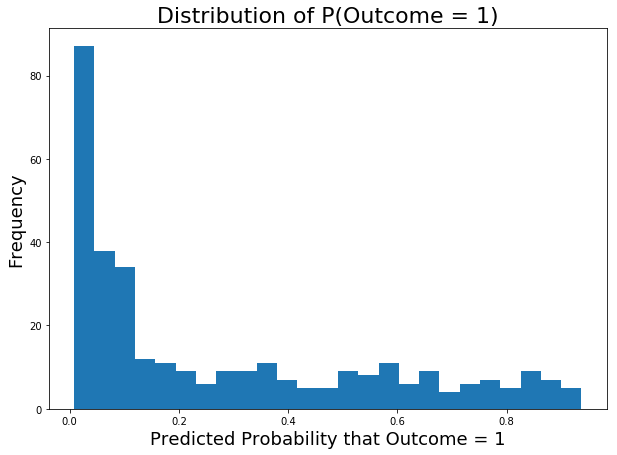

In [40]:
# Create figure.
plt.figure(figsize = (10,7))

# Create histogram of observations.
plt.hist(pred_df['pred_probs'], bins=25)

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

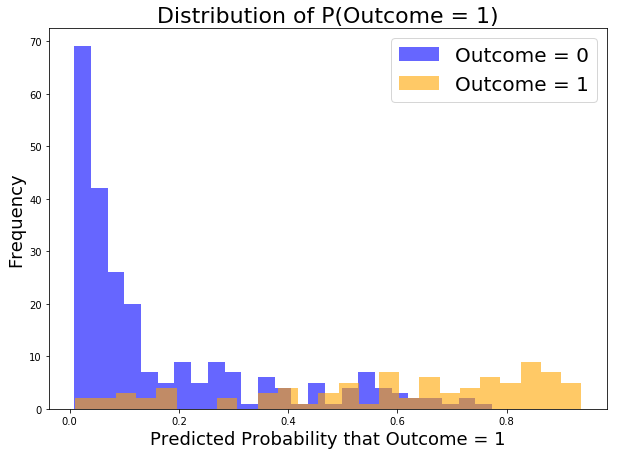

In [41]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],    #actually alive
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],    #actually dead
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

<details><summary>What do you notice about this distribution?</summary>

- Way more blue than orange.
- There's lots of overlap!
</details>

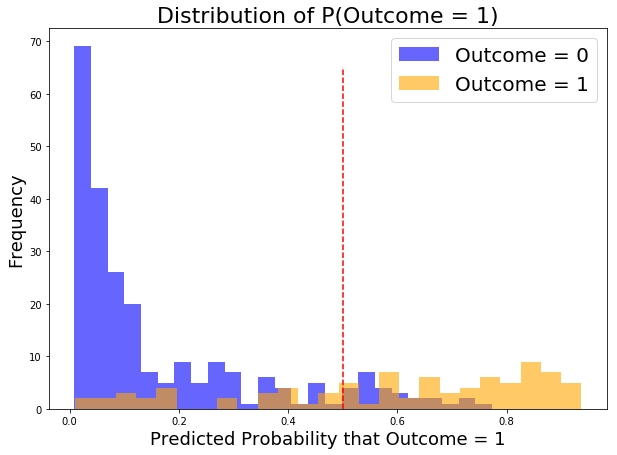

In [42]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],    #actually alive
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],    #actually dead
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 65,
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

<details><summary>Where are my true positives, true negatives, false positives, false negatives in this image?</summary>
    
- True Positive:
    - Items I correctly predict to be positive.
    - The orange bars (actual `1`) that are to the right of the red line (predicted `1`).
- True Negative: 
    - Items I correctly predict to be negative.
    - The blue bars (actual `0`) that are to the left of the red line (predicted `0`).
- False Positive:
    - Items I incorrectly predict to be positive.
    - The blue bars (actual `0`) that are to the right of the red line (predicted `1`).
- False Negative: 
    - Items I incorrectly predict to be negative.
    - The orange bars (actual `1`) that are to the left of the red line (predicted `0`).
</details>

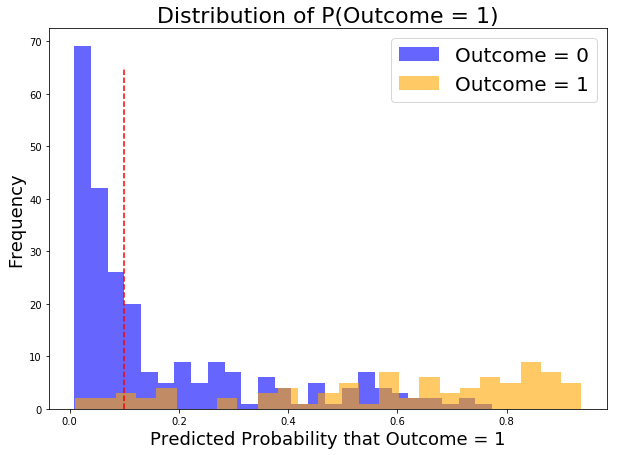

In [43]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],    #actually alive
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],    #actually dead
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.1.
plt.vlines(x=0.1,
           ymin = 0,
           ymax = 65,
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

<details><summary>When I moved my classification threshold to the left, what happened to sensitivity and specificity?</summary>

- Our number of true negatives decreased and our number of false positives increased.
    - $\text{Specificity} = \frac{TN}{TN + FP} \Rightarrow \text{Specificity decreases.}$
- Our number of true positives increased and our number of false negatives decreased.
    - $\text{Sensitivity} = \frac{TP}{TP + FN} \Rightarrow \text{Sensitivity increases.}$
</details>

---

Our goal should be to build a model such that there is **no overlap** between the blue histogram and the orange histogram!
- If there is overlap, we need to recognize the tradeoff between sensitivity and specificity. (As one increases, the other decreases.)
- One measure of how much overlap exists between our distributions is the **area under the ROC curve**.

## Receiver Operating Characteristic (ROC) Curve

The Receiver Operating Characteristic curve is a way to visualize the overlap between our positive class and negative class by moving our classification threshold from 0 to 1.
- We start our classification threshold (dashed red line) at 0.
- We calculate sensitivity and 1 - specificity.
- We plot the value of (x = sensitivity, y = 1 - specificity).
- We increase our classification threshold a small number (like 0.005).
- We calculate sensitivity and 1 - specificity.
- We plot the value of (x = sensitivity, y = 1 - specificity).
- We repeat until our threshold is equal to 1.

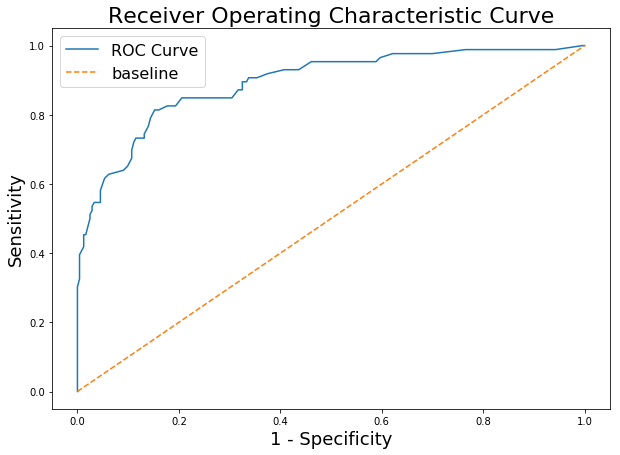

In [44]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

### ROC AUC

The more area under this blue curve is, the better separated our distributions are.
- Check out [this gif](https://twitter.com/DrHughHarvey/status/1104435699095404544).

We use the **area under the ROC curve** (abbreviated **ROC AUC** or **AUC ROC**) to quantify the gap between our distributions.

<details><summary>Note: Not to be confused with the ROC AOC.</summary>
<img src="./images/AOC.jpg" alt="AOC" width="400"/>
Disclaimer: AOC ROC is not a meaningful metric.
</details>

In [45]:
# Import roc_auc_score.
from sklearn.metrics import roc_auc_score

In [103]:
# Calculate score.
roc_auc_score(pred_df['true_values'], pred_df['pred_probs'])

0.8917360512967748

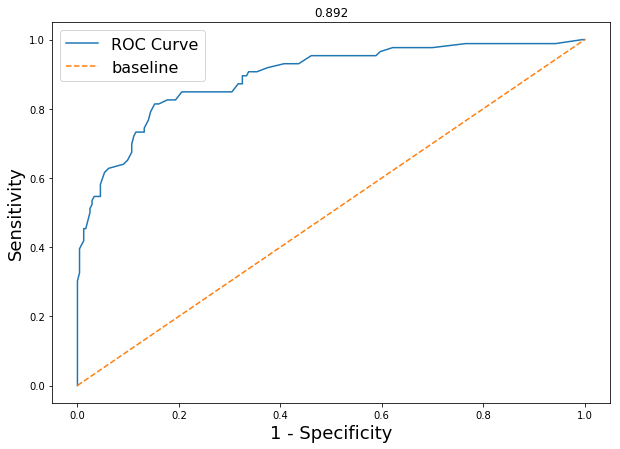

In [111]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
# plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df['true_values'], pred_df['pred_probs']),3)}', fontsize=22)
plt.title(round(roc_auc_score(pred_df['true_values'], pred_df['pred_probs']),3))
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

### Interpreting ROC AUC
- If you have an ROC AUC of 0.5, your positive and negative populations perfectly overlap and your model is as bad as it can get.
- If you have an ROC AUC of 1, your positive and negative populations are perfectly separated and your model is as good as it can get.
- The closer your ROC AUC is to 1, the better. (1 is the maximum score.)
- If you have an ROC AUC of below 0.5, your positive and negative distributions have flipped sides. By flipping your predicted values (i.e. flipping predicted 1s and 0s), your ROC AUC will now be above 0.5.
    - Example: You have an ROC AUC of 0.2. If you change your predicted 1s to 0s and your predicted 0s to 1s, your ROC AUC will now be 0.8! NOTE: means only flipping the Predicted's 1s to 0s, NOT the Actual's 1s to 0s
    
    (to see how it is so: flip the i[1] to i[0] in the line of code near beginning of notebook, which is...
    
    pred_proba = [i[1] for i in lr.predict_proba(X_test)]    #[0] contains 1-p, [1] contains p)

We generate one ROC curve per model. The ROC curve is generated by varying our threshold from 0 to 1. This doesn't actually change the threshold or our original predictions, but it helps us to visualize our tradeoff between _sensitivity_ and _specificity_ and understand how well-separated our populations are.

### Balanced / Unbalanced Classes

Suppose I want to predict the incidence of West Nile Virus (WNV) in Chicago.
- 99.9% of my observations are "no WNV."
- 0.1% of my observations contain "WNV."

If we fit a model and tried to optimize for accuracy, I can predict "no WNV" for every location and have an accuracy score that is really, _really_ good!

<details><summary>Why is this a bad model?</summary>
    
- We'll never predict that a location has West Nile Virus, which is probably going to lead to outbreaks of the disease.
</details>

In classification problems, methods generally better when we have roughly equally-sized classes. (i.e. 50% in the positive class and 50% in the negative class for binary classification problems).

#### Methods for Dealing with Unbalanced Classes

- **Bias correction.** Gary King wrote a [great whitepaper](https://gking.harvard.edu/files/gking/files/0s.pdf) on this topic.  This is a rigorous approach and while provide good results, as data scientists we prefer "easier" methods.


- **Weighting observations.** Some models allow the weighting of classes such as linear and logistic regression, Naive Bayes, Random Forests, SVMs, etc.


- **Stratified cross-validation.** If we use $k$-fold cross-validation entirely randomly, we may run into issues where some of our folds have no observations from the minority class.

<img src="https://snag.gy/PqISr3.jpg">

By stratifying on our output variable with unbalanced classes during cross- validation, we protect ourselves from this situation and ensure that our estimate of our model performance has lower variance.


- **Changing threshold for classification.**
By adjusting our classification threshold, we might find a better fit for our particular use-case.  We performed this operation earlier by manually changing our predicted labels by choosing a new threshold from the predicted probability.


- **Purposefully optimizing evaluation metrics.**
We might also consider optimizating our model for a specific metric such as precision, recall by class, ROC AUC.